<a href="https://colab.research.google.com/github/IsokGta7/IsokGta7.github.io/blob/main/Tareas/TC-09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Trabajo en clase 9</h1>

<h2>Topic Modelling</h1>

Haremos Topic Modelling usando varias técnicas:

* Clustering en representaciones vectoriales de documentos BOW y TF-IDF.
* LSA, implementación en [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

Posteriormente, usaras:
* LDA. Implementación en [gensim](https://radimrehurek.com/gensim/models/ldamodel.html).

Además, evaluaremos estas tareas usando métricas propias de la tarea.
* [Coherence](https://radimrehurek.com/gensim/models/coherencemodel.html): [source](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

Corpus:

In [1]:
!gdown 19Kp2DpVtPVe4kDN7yhNwlquiteUfqaFP

Downloading...
From: https://drive.google.com/uc?id=19Kp2DpVtPVe4kDN7yhNwlquiteUfqaFP
To: /content/topic_modelling_dataset.csv
100% 9.11M/9.11M [00:00<00:00, 53.5MB/s]


In [2]:
import pandas as pd

tm_df = pd.read_csv('topic_modelling_dataset.csv')

In [4]:
!pip install kneed

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from kneed import KneeLocator
import math

In [8]:
# Descargar datos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Instrucciones

1. Hacer un preprocesamiento básico que consideres necesario.
2. Realizar las vectorizaciones BOW y TF-IDF
3. Realiza clustering con K-Means, escogiendo el valor de $K$ dado por el valor de codo.
4. Evalua ambas tareas de clustering con el score de Silueta.
5. Con el mismo número de tópicos del punto 3, haz topic modelling con LSA (escoge BOW o TF-IDF).
6. Evalua la tarea con la métrica Coherencia UMASS (usa la implementación de abajo).

In [9]:
# Preprocesamiento básico
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

tm_df['processed'] = tm_df['text'].apply(preprocess)

In [10]:
# Vectorización BOW y TF-IDF
bow_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
bow_matrix = bow_vectorizer.fit_transform(tm_df['processed'])

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(tm_df['processed'])

In [11]:
# Función para encontrar K óptimo usando el método del codo
def find_optimal_k(matrix, vectorization_name):
    inertias = []
    K_range = range(2, 11)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(matrix)
        inertias.append(kmeans.inertia_)

    # Determinar el punto de codo
    kneedle = KneeLocator(K_range, inertias, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertias, 'bx-')
    plt.xlabel('Número de clusters (K)')
    plt.ylabel('Inercia')
    plt.title(f'Método del Codo para {vectorization_name}')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
    plt.show()

    return optimal_k

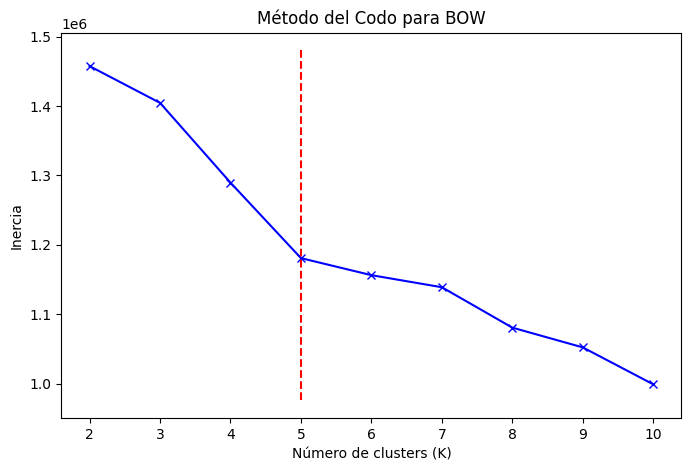

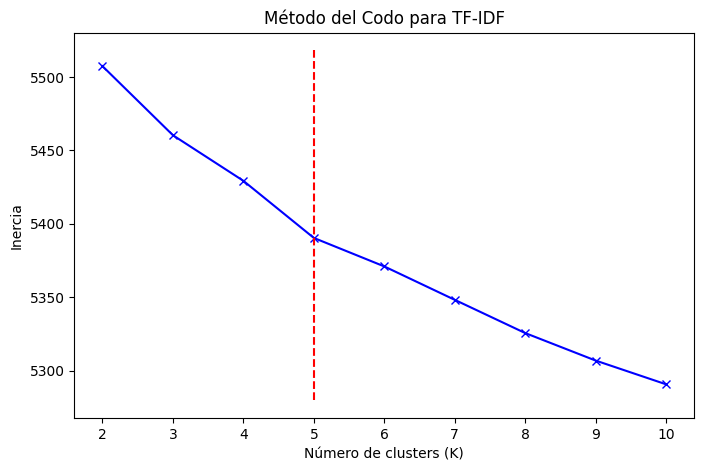

In [12]:
# Encontrar K óptimo para BOW y TF-IDF
k_bow = find_optimal_k(bow_matrix, 'BOW')
k_tfidf = find_optimal_k(tfidf_matrix, 'TF-IDF')

In [13]:
# Clustering y evaluación con Silhouette
def evaluate_clustering(matrix, k, vectorization_name):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(matrix)
    score = silhouette_score(matrix, labels)
    print(f'Silhouette Score ({vectorization_name}): {score:.4f}')

print("\nEvaluación de Clustering:")
evaluate_clustering(bow_matrix, k_bow, 'BOW')
evaluate_clustering(tfidf_matrix, k_tfidf, 'TF-IDF')


Evaluación de Clustering:
Silhouette Score (BOW): 0.6818
Silhouette Score (TF-IDF): 0.0150


In [14]:
# Topic Modelling con LSA (usando TF-IDF y K del clustering)
print("\nTopic Modelling con LSA:")
lsa = TruncatedSVD(n_components=k_tfidf, random_state=42)
lsa.fit(tfidf_matrix)
topics = lsa.components_


Topic Modelling con LSA:


In [15]:
# Función de coherencia (proporcionada)
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = (col_i + col_j == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = list(enumerate(topic))
    topic_top = sorted(indexed_topic, key=lambda x: -x[1])[:n_top_words]
    coherence = 0
    for j in range(1, len(topic_top)):
        for i in range(j):
            term_i = topic_top[i][0]
            term_j = topic_top[j][0]
            coherence += get_umass_score(dt_matrix, term_i, term_j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total = 0
    for topic in topics:
        total += get_topic_coherence(dt_matrix, topic, n_top_words)
    return total / len(topics)

In [16]:
# Calcular coherencia
n_top_words = 10
average_coherence = get_average_topic_coherence(tfidf_matrix, topics, n_top_words)
print(f'Coherencia Promedio (UMASS): {average_coherence:.4f}')

Coherencia Promedio (UMASS): -77.6313


In [17]:
# Mostrar palabras clave de los tópicos (opcional)
feature_names = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(topics):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f'Tópico {idx+1}: {", ".join(top_words)}')

Tópico 1: pizza, order, dominos, delivery, time, ordered, would, one, get, food
Tópico 2: pizza, order, dominos, delivery, ordered, minutes, store, food, location, service
Tópico 3: pizza, always, dominos, good, crust, great, fast, cheese, sauce, friendly
Tópico 4: armenian, pizza, turkish, armenians, armenia, turks, genocide, muslim, turkey, extermination
Tópico 5: always, food, armenian, turkish, armenians, order, service, delivery, great, dominos
